In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle


from tensorflow.keras.layers import Dropout,MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [2]:
import os
path, dirs, files = next(os.walk("D:\\code\\Fiona\\climate project\\New Data\\profiles"))
file_count = len(files)
print('The number of profiles:',file_count)

The number of profiles: 4000


In [3]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

# get spatial dimension
fname = "D:\\code\\Fiona\\climate project\\New Data\\profiles/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

In [4]:
#get the averaged reflectance from the dataset 
fname_r = "data_reflectance.h5"
hf_r = h5py.File(fname_r, 'r')
r=hf_r['dataset_reflectance']
r.shape

(4000, 82)

In [5]:
#get the averaged reflectance from the dataset 
fname_c = "data_cot.h5"
hf_c = h5py.File(fname_c, 'r')
c=hf_c['dataset_cot']
c.shape

(4000, 82)

In [6]:
c=c[:]
r=r[:]

In [7]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')

# spatial slicing dimensions
os = 82 # output slice size
ts = os # input slice size 32


train_size: 3200 profiles
test_size: 800 profiles


In [11]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 82
eps = 2000


input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
#patch embedding layer
#The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
projection=tf.keras.layers.Dense(82,activation='relu')(input_layer)
positions = tf.range(start=0, limit=82, delta=1)
embedding=tf.keras.layers.Embedding(input_dim=(82),output_dim=(82),input_length=82)(positions)
# adds a learnable position embedding to the projected vector
encoded = projection+embedding

bi=Bidirectional(tf.keras.layers.LSTM(units=82, activation='tanh',return_sequences = True))(encoded) #kernel size 6, 100 filters for each 3 channel
bi=Bidirectional(tf.keras.layers.LSTM(units=82, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel

#position_embedding=layers.Embedding(input_dim=256, output_dim=256,input_length=32)(bi)

#transformer block
slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(bi,bi)
add1=tf.keras.layers.Add()([slf_attn,bi])
layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
dense1=tf.keras.layers.Dense(164,activation='relu')(layernorm1)
add2=tf.keras.layers.Add()([layernorm1,dense1])
layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)

#pooling
avg_pool = GlobalAveragePooling1D()(layernorm2)
max_pool = GlobalMaxPooling1D()(layernorm2)
conc = concatenate([avg_pool, max_pool])

#output layers
dense2 = tf.keras.layers.Dense(42*3,activation='relu')(conc)
output = tf.keras.layers.Dense(os,activation='relu')(dense2)

model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 1)]      0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 82, 82)       164         Input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.add_1 (TFOpLam (None, 82, 82)       0           dense_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 82, 164)      108240      tf.__operators__.add_1[0][0]     
____________________________________________________________________________________________

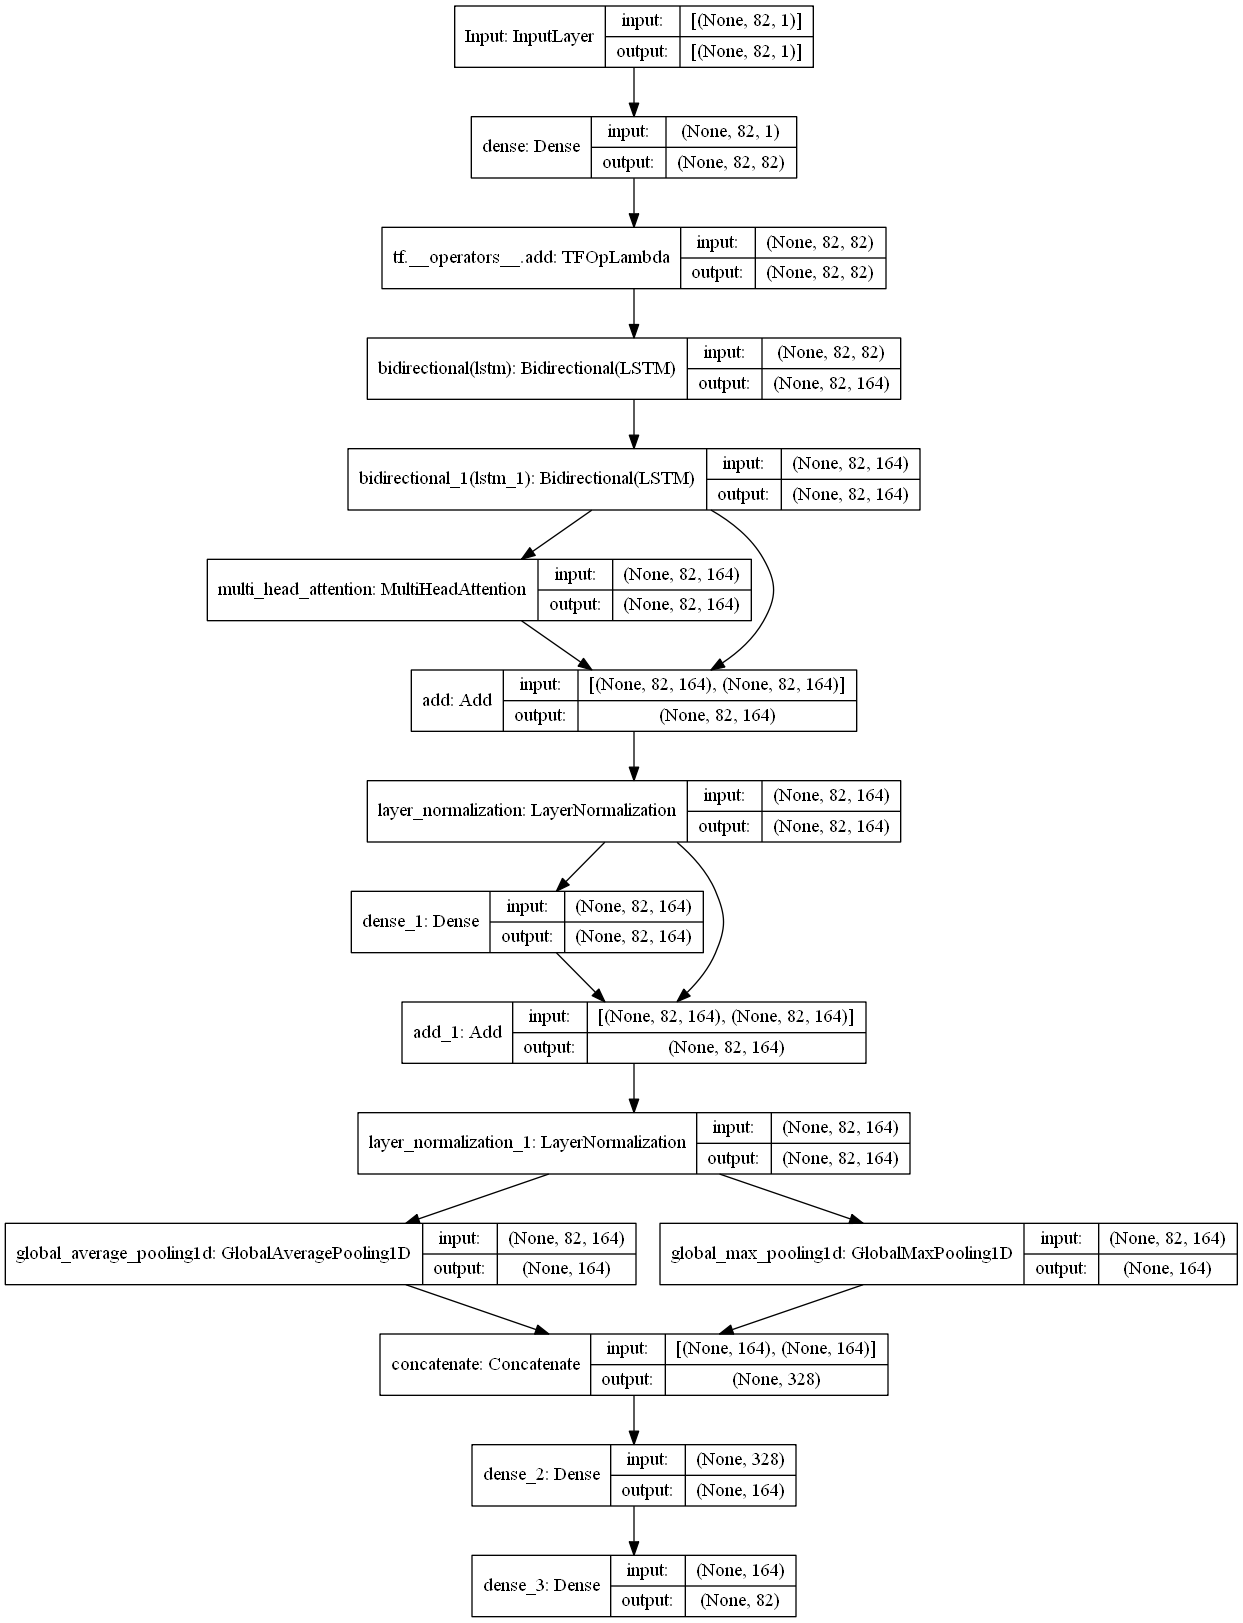

In [14]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

In [11]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 16
eps = 2000

def eval_model(train_image, test_image, train_label, test_label):

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
    projection=tf.keras.layers.Dense(64,activation='relu')(input_layer)
    positions = tf.range(start=0, limit=82, delta=1)
    embedding=tf.keras.layers.Embedding(input_dim=(82),output_dim=(64),input_length=128)(positions)
    # adds a learnable position embedding to the projected vector
    encoded = projection+embedding

    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(encoded) #kernel size 6, 100 filters for each 3 channel
    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel


    #transformer block
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(bi,bi)
    add1=tf.keras.layers.Add()([slf_attn,bi])
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
    dense1=tf.keras.layers.Dense(256,activation='relu')(layernorm1)
    add2=tf.keras.layers.Add()([layernorm1,dense1])
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)
    
    
    
    flat=tf.keras.layers.Flatten()(layernorm2)

    #pooling
   # avg_pool = GlobalAveragePooling1D()(layernorm2)
  #  max_pool = GlobalMaxPooling1D()(layernorm2)
   # conc = concatenate([avg_pool, max_pool])

    #output layers
   # dense2 = tf.keras.layers.Dense(42*3,activation='relu')(conc)
    drop=tf.keras.layers.Dropout(.2)(flat)

    output = tf.keras.layers.Dense(os,activation='relu')(drop)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()
    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    #checkpoint_path='training/cp-{epoch:04d}.ckpt'
    #checkpoint_dir=os.path.dirname(checkpoint_path)
    
  #  cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,save_freq=5*bsize)
   # model.save_weights(checkpoint_path.format(epoch=0))

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions,results

In [12]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,ts))
y_train=np.zeros((5,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [13]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions,results= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)




   



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 1)]      0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 82, 64)       128         Input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.add_1 (TFOpLam (None, 82, 64)       0           dense_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 82, 256)      197632      tf.__operators__.add_1[0][0]     
____________________________________________________________________________________________

175/175 [==============================] - 5s 26ms/step - loss: 0.4635 - mean_squared_error: 0.4635 - root_mean_squared_error: 0.6808 - val_loss: 0.4984 - val_mean_squared_error: 0.4984 - val_root_mean_squared_error: 0.7060
Epoch 55/2000
175/175 [==============================] - 5s 27ms/step - loss: 0.4603 - mean_squared_error: 0.4603 - root_mean_squared_error: 0.6784 - val_loss: 0.5028 - val_mean_squared_error: 0.5028 - val_root_mean_squared_error: 0.7091
Epoch 56/2000
175/175 [==============================] - 6s 32ms/step - loss: 0.4437 - mean_squared_error: 0.4437 - root_mean_squared_error: 0.6660 - val_loss: 0.5026 - val_mean_squared_error: 0.5026 - val_root_mean_squared_error: 0.7089
Epoch 57/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.4492 - mean_squared_error: 0.4492 - root_mean_squared_error: 0.6702 - val_loss: 0.5366 - val_mean_squared_error: 0.5366 - val_root_mean_squared_error: 0.7325
Epoch 58/2000
175/175 [==============================] - 5s 30

175/175 [==============================] - 5s 28ms/step - loss: 0.2736 - mean_squared_error: 0.2736 - root_mean_squared_error: 0.5230 - val_loss: 0.3829 - val_mean_squared_error: 0.3829 - val_root_mean_squared_error: 0.6188
Epoch 123/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2645 - mean_squared_error: 0.2645 - root_mean_squared_error: 0.5143 - val_loss: 0.3932 - val_mean_squared_error: 0.3932 - val_root_mean_squared_error: 0.6271
Epoch 124/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2768 - mean_squared_error: 0.2768 - root_mean_squared_error: 0.5261 - val_loss: 0.4491 - val_mean_squared_error: 0.4491 - val_root_mean_squared_error: 0.6702
Epoch 125/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2780 - mean_squared_error: 0.2780 - root_mean_squared_error: 0.5272 - val_loss: 0.3819 - val_mean_squared_error: 0.3819 - val_root_mean_squared_error: 0.6180
Epoch 126/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.2012 - mean_squared_error: 0.2012 - root_mean_squared_error: 0.4485 - val_loss: 0.3557 - val_mean_squared_error: 0.3557 - val_root_mean_squared_error: 0.5964
Epoch 191/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2074 - mean_squared_error: 0.2074 - root_mean_squared_error: 0.4554 - val_loss: 0.3474 - val_mean_squared_error: 0.3474 - val_root_mean_squared_error: 0.5894
Epoch 192/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2067 - mean_squared_error: 0.2067 - root_mean_squared_error: 0.4546 - val_loss: 0.3566 - val_mean_squared_error: 0.3566 - val_root_mean_squared_error: 0.5971
Epoch 193/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2084 - mean_squared_error: 0.2084 - root_mean_squared_error: 0.4565 - val_loss: 0.3660 - val_mean_squared_error: 0.3660 - val_root_mean_squared_error: 0.6050
Epoch 194/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1812 - mean_squared_error: 0.1812 - root_mean_squared_error: 0.4257 - val_loss: 0.3236 - val_mean_squared_error: 0.3236 - val_root_mean_squared_error: 0.5688
Epoch 259/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1815 - mean_squared_error: 0.1815 - root_mean_squared_error: 0.4259 - val_loss: 0.3202 - val_mean_squared_error: 0.3202 - val_root_mean_squared_error: 0.5659
Epoch 260/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1762 - mean_squared_error: 0.1762 - root_mean_squared_error: 0.4197 - val_loss: 0.3291 - val_mean_squared_error: 0.3291 - val_root_mean_squared_error: 0.5736
Epoch 261/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1785 - mean_squared_error: 0.1785 - root_mean_squared_error: 0.4225 - val_loss: 0.3368 - val_mean_squared_error: 0.3368 - val_root_mean_squared_error: 0.5804
Epoch 262/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1593 - mean_squared_error: 0.1593 - root_mean_squared_error: 0.3992 - val_loss: 0.3036 - val_mean_squared_error: 0.3036 - val_root_mean_squared_error: 0.5510
Epoch 327/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1641 - mean_squared_error: 0.1641 - root_mean_squared_error: 0.4050 - val_loss: 0.3128 - val_mean_squared_error: 0.3128 - val_root_mean_squared_error: 0.5593
Epoch 328/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1568 - mean_squared_error: 0.1568 - root_mean_squared_error: 0.3959 - val_loss: 0.3185 - val_mean_squared_error: 0.3185 - val_root_mean_squared_error: 0.5644
Epoch 329/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1616 - mean_squared_error: 0.1616 - root_mean_squared_error: 0.4020 - val_loss: 0.3214 - val_mean_squared_error: 0.3214 - val_root_mean_squared_error: 0.5669
Epoch 330/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1508 - mean_squared_error: 0.1508 - root_mean_squared_error: 0.3883 - val_loss: 0.2863 - val_mean_squared_error: 0.2863 - val_root_mean_squared_error: 0.5351
Epoch 395/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1452 - mean_squared_error: 0.1452 - root_mean_squared_error: 0.3810 - val_loss: 0.2945 - val_mean_squared_error: 0.2945 - val_root_mean_squared_error: 0.5427
Epoch 396/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1519 - mean_squared_error: 0.1519 - root_mean_squared_error: 0.3897 - val_loss: 0.2894 - val_mean_squared_error: 0.2894 - val_root_mean_squared_error: 0.5379
Epoch 397/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1436 - mean_squared_error: 0.1436 - root_mean_squared_error: 0.3790 - val_loss: 0.3143 - val_mean_squared_error: 0.3143 - val_root_mean_squared_error: 0.5606
Epoch 398/2000
175/175 [==============================] - 5

175/175 [==============================] - 12s 40ms/step - loss: 64.5606 - mean_squared_error: 64.5606 - root_mean_squared_error: 5.5801 - val_loss: 18.5816 - val_mean_squared_error: 18.5816 - val_root_mean_squared_error: 4.3106
Epoch 2/2000
175/175 [==============================] - 5s 28ms/step - loss: 17.2577 - mean_squared_error: 17.2577 - root_mean_squared_error: 4.1525 - val_loss: 12.6982 - val_mean_squared_error: 12.6982 - val_root_mean_squared_error: 3.5635
Epoch 3/2000
175/175 [==============================] - 5s 28ms/step - loss: 12.4415 - mean_squared_error: 12.4415 - root_mean_squared_error: 3.5265 - val_loss: 9.7646 - val_mean_squared_error: 9.7646 - val_root_mean_squared_error: 3.1248
Epoch 4/2000
175/175 [==============================] - 5s 28ms/step - loss: 10.5539 - mean_squared_error: 10.5539 - root_mean_squared_error: 3.2476 - val_loss: 8.9809 - val_mean_squared_error: 8.9809 - val_root_mean_squared_error: 2.9968
Epoch 5/2000
175/175 [==============================

175/175 [==============================] - 5s 30ms/step - loss: 0.4089 - mean_squared_error: 0.4089 - root_mean_squared_error: 0.6395 - val_loss: 0.4683 - val_mean_squared_error: 0.4683 - val_root_mean_squared_error: 0.6843
Epoch 70/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.4129 - mean_squared_error: 0.4129 - root_mean_squared_error: 0.6426 - val_loss: 0.4622 - val_mean_squared_error: 0.4622 - val_root_mean_squared_error: 0.6798
Epoch 71/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.3928 - mean_squared_error: 0.3928 - root_mean_squared_error: 0.6268 - val_loss: 0.4646 - val_mean_squared_error: 0.4646 - val_root_mean_squared_error: 0.6816
Epoch 72/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.3862 - mean_squared_error: 0.3862 - root_mean_squared_error: 0.6214 - val_loss: 0.4578 - val_mean_squared_error: 0.4578 - val_root_mean_squared_error: 0.6766
Epoch 73/2000
175/175 [==============================] - 5s 29

175/175 [==============================] - 5s 28ms/step - loss: 0.2568 - mean_squared_error: 0.2568 - root_mean_squared_error: 0.5068 - val_loss: 0.3966 - val_mean_squared_error: 0.3966 - val_root_mean_squared_error: 0.6297
Epoch 138/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2586 - mean_squared_error: 0.2586 - root_mean_squared_error: 0.5085 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - val_root_mean_squared_error: 0.5988
Epoch 139/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2463 - mean_squared_error: 0.2463 - root_mean_squared_error: 0.4963 - val_loss: 0.3997 - val_mean_squared_error: 0.3997 - val_root_mean_squared_error: 0.6322
Epoch 140/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2481 - mean_squared_error: 0.2481 - root_mean_squared_error: 0.4981 - val_loss: 0.3646 - val_mean_squared_error: 0.3646 - val_root_mean_squared_error: 0.6038
Epoch 141/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1951 - mean_squared_error: 0.1951 - root_mean_squared_error: 0.4417 - val_loss: 0.3392 - val_mean_squared_error: 0.3392 - val_root_mean_squared_error: 0.5824
Epoch 206/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2078 - mean_squared_error: 0.2078 - root_mean_squared_error: 0.4558 - val_loss: 0.3643 - val_mean_squared_error: 0.3643 - val_root_mean_squared_error: 0.6036
Epoch 207/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2127 - mean_squared_error: 0.2127 - root_mean_squared_error: 0.4612 - val_loss: 0.3299 - val_mean_squared_error: 0.3299 - val_root_mean_squared_error: 0.5744
Epoch 208/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1995 - mean_squared_error: 0.1995 - root_mean_squared_error: 0.4466 - val_loss: 0.3543 - val_mean_squared_error: 0.3543 - val_root_mean_squared_error: 0.5952
Epoch 209/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1756 - mean_squared_error: 0.1756 - root_mean_squared_error: 0.4191 - val_loss: 0.3235 - val_mean_squared_error: 0.3235 - val_root_mean_squared_error: 0.5688
Epoch 274/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1782 - mean_squared_error: 0.1782 - root_mean_squared_error: 0.4221 - val_loss: 0.3422 - val_mean_squared_error: 0.3422 - val_root_mean_squared_error: 0.5850
Epoch 275/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1866 - mean_squared_error: 0.1866 - root_mean_squared_error: 0.4319 - val_loss: 0.3099 - val_mean_squared_error: 0.3099 - val_root_mean_squared_error: 0.5566
Epoch 276/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1733 - mean_squared_error: 0.1733 - root_mean_squared_error: 0.4162 - val_loss: 0.3225 - val_mean_squared_error: 0.3225 - val_root_mean_squared_error: 0.5679
Epoch 277/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1605 - mean_squared_error: 0.1605 - root_mean_squared_error: 0.4006 - val_loss: 0.3000 - val_mean_squared_error: 0.3000 - val_root_mean_squared_error: 0.5477
Epoch 342/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1596 - mean_squared_error: 0.1596 - root_mean_squared_error: 0.3995 - val_loss: 0.3035 - val_mean_squared_error: 0.3035 - val_root_mean_squared_error: 0.5509
Epoch 343/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1598 - mean_squared_error: 0.1598 - root_mean_squared_error: 0.3997 - val_loss: 0.3037 - val_mean_squared_error: 0.3037 - val_root_mean_squared_error: 0.5511
Epoch 344/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1606 - mean_squared_error: 0.1606 - root_mean_squared_error: 0.4007 - val_loss: 0.2922 - val_mean_squared_error: 0.2922 - val_root_mean_squared_error: 0.5406
Epoch 345/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1554 - mean_squared_error: 0.1554 - root_mean_squared_error: 0.3941 - val_loss: 0.2887 - val_mean_squared_error: 0.2887 - val_root_mean_squared_error: 0.5373
Epoch 410/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1600 - mean_squared_error: 0.1600 - root_mean_squared_error: 0.3999 - val_loss: 0.2912 - val_mean_squared_error: 0.2912 - val_root_mean_squared_error: 0.5396
Epoch 411/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1470 - mean_squared_error: 0.1470 - root_mean_squared_error: 0.3834 - val_loss: 0.2973 - val_mean_squared_error: 0.2973 - val_root_mean_squared_error: 0.5453
Epoch 412/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1501 - mean_squared_error: 0.1501 - root_mean_squared_error: 0.3874 - val_loss: 0.2960 - val_mean_squared_error: 0.2960 - val_root_mean_squared_error: 0.5440
Epoch 413/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 3.1492 - mean_squared_error: 3.1492 - root_mean_squared_error: 1.7742 - val_loss: 3.5429 - val_mean_squared_error: 3.5429 - val_root_mean_squared_error: 1.8823
Epoch 49/2000
175/175 [==============================] - 5s 28ms/step - loss: 3.2394 - mean_squared_error: 3.2394 - root_mean_squared_error: 1.7997 - val_loss: 3.6058 - val_mean_squared_error: 3.6058 - val_root_mean_squared_error: 1.8989
Epoch 50/2000
175/175 [==============================] - 5s 28ms/step - loss: 3.2219 - mean_squared_error: 3.2219 - root_mean_squared_error: 1.7944 - val_loss: 3.5821 - val_mean_squared_error: 3.5821 - val_root_mean_squared_error: 1.8926
Epoch 51/2000
175/175 [==============================] - 5s 28ms/step - loss: 3.0465 - mean_squared_error: 3.0465 - root_mean_squared_error: 1.7440 - val_loss: 3.5828 - val_mean_squared_error: 3.5828 - val_root_mean_squared_error: 1.8928
Epoch 52/2000
175/175 [==============================] - 5s 28

175/175 [==============================] - 5s 28ms/step - loss: 0.2970 - mean_squared_error: 0.2970 - root_mean_squared_error: 0.5450 - val_loss: 0.3976 - val_mean_squared_error: 0.3976 - val_root_mean_squared_error: 0.6306
Epoch 117/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2794 - mean_squared_error: 0.2794 - root_mean_squared_error: 0.5286 - val_loss: 0.4202 - val_mean_squared_error: 0.4202 - val_root_mean_squared_error: 0.6482
Epoch 118/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2825 - mean_squared_error: 0.2825 - root_mean_squared_error: 0.5315 - val_loss: 0.3805 - val_mean_squared_error: 0.3805 - val_root_mean_squared_error: 0.6169
Epoch 119/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2834 - mean_squared_error: 0.2834 - root_mean_squared_error: 0.5323 - val_loss: 0.3687 - val_mean_squared_error: 0.3687 - val_root_mean_squared_error: 0.6072
Epoch 120/2000
175/175 [==============================] - 5

175/175 [==============================] - 8s 47ms/step - loss: 0.2156 - mean_squared_error: 0.2156 - root_mean_squared_error: 0.4643 - val_loss: 0.3473 - val_mean_squared_error: 0.3473 - val_root_mean_squared_error: 0.5893
Epoch 185/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2195 - mean_squared_error: 0.2195 - root_mean_squared_error: 0.4685 - val_loss: 0.3426 - val_mean_squared_error: 0.3426 - val_root_mean_squared_error: 0.5853
Epoch 186/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2209 - mean_squared_error: 0.2209 - root_mean_squared_error: 0.4700 - val_loss: 0.3383 - val_mean_squared_error: 0.3383 - val_root_mean_squared_error: 0.5816
Epoch 187/2000
175/175 [==============================] - 5s 29ms/step - loss: 0.2060 - mean_squared_error: 0.2060 - root_mean_squared_error: 0.4538 - val_loss: 0.3425 - val_mean_squared_error: 0.3425 - val_root_mean_squared_error: 0.5852
Epoch 188/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1888 - mean_squared_error: 0.1888 - root_mean_squared_error: 0.4345 - val_loss: 0.3416 - val_mean_squared_error: 0.3416 - val_root_mean_squared_error: 0.5844
Epoch 253/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1914 - mean_squared_error: 0.1914 - root_mean_squared_error: 0.4375 - val_loss: 0.3553 - val_mean_squared_error: 0.3553 - val_root_mean_squared_error: 0.5960
Epoch 254/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1878 - mean_squared_error: 0.1878 - root_mean_squared_error: 0.4334 - val_loss: 0.3159 - val_mean_squared_error: 0.3159 - val_root_mean_squared_error: 0.5620
Epoch 255/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1826 - mean_squared_error: 0.1826 - root_mean_squared_error: 0.4274 - val_loss: 0.3080 - val_mean_squared_error: 0.3080 - val_root_mean_squared_error: 0.5550
Epoch 256/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1629 - mean_squared_error: 0.1629 - root_mean_squared_error: 0.4036 - val_loss: 0.3296 - val_mean_squared_error: 0.3296 - val_root_mean_squared_error: 0.5741
Epoch 321/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1754 - mean_squared_error: 0.1754 - root_mean_squared_error: 0.4188 - val_loss: 0.3016 - val_mean_squared_error: 0.3016 - val_root_mean_squared_error: 0.5492
Epoch 322/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - root_mean_squared_error: 0.4202 - val_loss: 0.3005 - val_mean_squared_error: 0.3005 - val_root_mean_squared_error: 0.5481
Epoch 323/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1685 - mean_squared_error: 0.1685 - root_mean_squared_error: 0.4105 - val_loss: 0.2971 - val_mean_squared_error: 0.2971 - val_root_mean_squared_error: 0.5450
Epoch 324/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1592 - mean_squared_error: 0.1592 - root_mean_squared_error: 0.3990 - val_loss: 0.3068 - val_mean_squared_error: 0.3068 - val_root_mean_squared_error: 0.5539
Epoch 389/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1568 - mean_squared_error: 0.1568 - root_mean_squared_error: 0.3960 - val_loss: 0.2893 - val_mean_squared_error: 0.2893 - val_root_mean_squared_error: 0.5379
Epoch 390/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1571 - mean_squared_error: 0.1571 - root_mean_squared_error: 0.3963 - val_loss: 0.2926 - val_mean_squared_error: 0.2926 - val_root_mean_squared_error: 0.5409
Epoch 391/2000
175/175 [==============================] - 5s 29ms/step - loss: 0.1572 - mean_squared_error: 0.1572 - root_mean_squared_error: 0.3964 - val_loss: 0.2849 - val_mean_squared_error: 0.2849 - val_root_mean_squared_error: 0.5337
Epoch 392/2000
175/175 [==============================] - 6

175/175 [==============================] - 5s 27ms/step - loss: 0.5305 - mean_squared_error: 0.5305 - root_mean_squared_error: 0.7283 - val_loss: 0.5559 - val_mean_squared_error: 0.5559 - val_root_mean_squared_error: 0.7456
Epoch 46/2000
175/175 [==============================] - 5s 27ms/step - loss: 0.5177 - mean_squared_error: 0.5177 - root_mean_squared_error: 0.7195 - val_loss: 0.5492 - val_mean_squared_error: 0.5492 - val_root_mean_squared_error: 0.7411
Epoch 47/2000
175/175 [==============================] - 5s 27ms/step - loss: 0.5195 - mean_squared_error: 0.5195 - root_mean_squared_error: 0.7208 - val_loss: 0.5229 - val_mean_squared_error: 0.5229 - val_root_mean_squared_error: 0.7231
Epoch 48/2000
175/175 [==============================] - 5s 26ms/step - loss: 0.5186 - mean_squared_error: 0.5186 - root_mean_squared_error: 0.7201 - val_loss: 0.5347 - val_mean_squared_error: 0.5347 - val_root_mean_squared_error: 0.7312
Epoch 49/2000
175/175 [==============================] - 5s 26

175/175 [==============================] - 5s 28ms/step - loss: 0.3086 - mean_squared_error: 0.3086 - root_mean_squared_error: 0.5555 - val_loss: 0.4172 - val_mean_squared_error: 0.4172 - val_root_mean_squared_error: 0.6459
Epoch 114/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.3070 - mean_squared_error: 0.3070 - root_mean_squared_error: 0.5540 - val_loss: 0.4058 - val_mean_squared_error: 0.4058 - val_root_mean_squared_error: 0.6370
Epoch 115/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.3012 - mean_squared_error: 0.3012 - root_mean_squared_error: 0.5488 - val_loss: 0.4165 - val_mean_squared_error: 0.4165 - val_root_mean_squared_error: 0.6454
Epoch 116/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2950 - mean_squared_error: 0.2950 - root_mean_squared_error: 0.5431 - val_loss: 0.4001 - val_mean_squared_error: 0.4001 - val_root_mean_squared_error: 0.6325
Epoch 117/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.2252 - mean_squared_error: 0.2252 - root_mean_squared_error: 0.4744 - val_loss: 0.3838 - val_mean_squared_error: 0.3838 - val_root_mean_squared_error: 0.6195
Epoch 182/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2258 - mean_squared_error: 0.2258 - root_mean_squared_error: 0.4752 - val_loss: 0.4011 - val_mean_squared_error: 0.4011 - val_root_mean_squared_error: 0.6334
Epoch 183/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2304 - mean_squared_error: 0.2304 - root_mean_squared_error: 0.4800 - val_loss: 0.3900 - val_mean_squared_error: 0.3900 - val_root_mean_squared_error: 0.6245
Epoch 184/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2273 - mean_squared_error: 0.2273 - root_mean_squared_error: 0.4767 - val_loss: 0.3490 - val_mean_squared_error: 0.3490 - val_root_mean_squared_error: 0.5908
Epoch 185/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1915 - mean_squared_error: 0.1915 - root_mean_squared_error: 0.4376 - val_loss: 0.3366 - val_mean_squared_error: 0.3366 - val_root_mean_squared_error: 0.5802
Epoch 250/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1918 - mean_squared_error: 0.1918 - root_mean_squared_error: 0.4380 - val_loss: 0.3651 - val_mean_squared_error: 0.3651 - val_root_mean_squared_error: 0.6042
Epoch 251/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1966 - mean_squared_error: 0.1966 - root_mean_squared_error: 0.4434 - val_loss: 0.3262 - val_mean_squared_error: 0.3262 - val_root_mean_squared_error: 0.5711
Epoch 252/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1895 - mean_squared_error: 0.1895 - root_mean_squared_error: 0.4353 - val_loss: 0.3192 - val_mean_squared_error: 0.3192 - val_root_mean_squared_error: 0.5650
Epoch 253/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1792 - mean_squared_error: 0.1792 - root_mean_squared_error: 0.4233 - val_loss: 0.3129 - val_mean_squared_error: 0.3129 - val_root_mean_squared_error: 0.5594
Epoch 318/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1720 - mean_squared_error: 0.1720 - root_mean_squared_error: 0.4148 - val_loss: 0.3309 - val_mean_squared_error: 0.3309 - val_root_mean_squared_error: 0.5753
Epoch 319/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1710 - mean_squared_error: 0.1710 - root_mean_squared_error: 0.4135 - val_loss: 0.3192 - val_mean_squared_error: 0.3192 - val_root_mean_squared_error: 0.5650
Epoch 320/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1868 - mean_squared_error: 0.1868 - root_mean_squared_error: 0.4322 - val_loss: 0.3706 - val_mean_squared_error: 0.3706 - val_root_mean_squared_error: 0.6087
Epoch 321/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1576 - mean_squared_error: 0.1576 - root_mean_squared_error: 0.3969 - val_loss: 0.3097 - val_mean_squared_error: 0.3097 - val_root_mean_squared_error: 0.5565
Epoch 386/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1565 - mean_squared_error: 0.1565 - root_mean_squared_error: 0.3956 - val_loss: 0.3018 - val_mean_squared_error: 0.3018 - val_root_mean_squared_error: 0.5493
Epoch 387/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1550 - mean_squared_error: 0.1550 - root_mean_squared_error: 0.3937 - val_loss: 0.3090 - val_mean_squared_error: 0.3090 - val_root_mean_squared_error: 0.5559
Epoch 388/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1552 - mean_squared_error: 0.1552 - root_mean_squared_error: 0.3940 - val_loss: 0.2933 - val_mean_squared_error: 0.2933 - val_root_mean_squared_error: 0.5416
Epoch 389/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1488 - mean_squared_error: 0.1488 - root_mean_squared_error: 0.3857 - val_loss: 0.2950 - val_mean_squared_error: 0.2950 - val_root_mean_squared_error: 0.5431
Epoch 454/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1506 - mean_squared_error: 0.1506 - root_mean_squared_error: 0.3880 - val_loss: 0.2869 - val_mean_squared_error: 0.2869 - val_root_mean_squared_error: 0.5356
Epoch 455/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1450 - mean_squared_error: 0.1450 - root_mean_squared_error: 0.3808 - val_loss: 0.2930 - val_mean_squared_error: 0.2930 - val_root_mean_squared_error: 0.5413
Epoch 456/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - root_mean_squared_error: 0.3819 - val_loss: 0.2889 - val_mean_squared_error: 0.2889 - val_root_mean_squared_error: 0.5375
Epoch 457/2000
175/175 [==============================] - 5

Epoch 13/2000
175/175 [==============================] - 5s 28ms/step - loss: 17.7454 - mean_squared_error: 17.7454 - root_mean_squared_error: 4.2112 - val_loss: 15.5176 - val_mean_squared_error: 15.5176 - val_root_mean_squared_error: 3.9392
Epoch 14/2000
175/175 [==============================] - 5s 28ms/step - loss: 17.5780 - mean_squared_error: 17.5780 - root_mean_squared_error: 4.1915 - val_loss: 15.4709 - val_mean_squared_error: 15.4709 - val_root_mean_squared_error: 3.9333
Epoch 15/2000
175/175 [==============================] - 5s 28ms/step - loss: 17.6035 - mean_squared_error: 17.6035 - root_mean_squared_error: 4.1948 - val_loss: 15.4462 - val_mean_squared_error: 15.4462 - val_root_mean_squared_error: 3.9302
Epoch 16/2000
175/175 [==============================] - 5s 28ms/step - loss: 17.4915 - mean_squared_error: 17.4915 - root_mean_squared_error: 4.1819 - val_loss: 15.4638 - val_mean_squared_error: 15.4638 - val_root_mean_squared_error: 3.9324
Epoch 17/2000
175/175 [=========

Epoch 47/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.5237 - mean_squared_error: 0.5237 - root_mean_squared_error: 0.7236 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - val_root_mean_squared_error: 0.7046
Epoch 48/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.5095 - mean_squared_error: 0.5095 - root_mean_squared_error: 0.7138 - val_loss: 0.5148 - val_mean_squared_error: 0.5148 - val_root_mean_squared_error: 0.7175
Epoch 49/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.4953 - mean_squared_error: 0.4953 - root_mean_squared_error: 0.7038 - val_loss: 0.4846 - val_mean_squared_error: 0.4846 - val_root_mean_squared_error: 0.6961
Epoch 50/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.4975 - mean_squared_error: 0.4975 - root_mean_squared_error: 0.7052 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - val_root_mean_squared_error: 0.7027
Epoch 51/2000
175/175 [=========================

175/175 [==============================] - 5s 28ms/step - loss: 0.2837 - mean_squared_error: 0.2837 - root_mean_squared_error: 0.5327 - val_loss: 0.3770 - val_mean_squared_error: 0.3770 - val_root_mean_squared_error: 0.6140
Epoch 116/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2840 - mean_squared_error: 0.2840 - root_mean_squared_error: 0.5329 - val_loss: 0.3525 - val_mean_squared_error: 0.3525 - val_root_mean_squared_error: 0.5937
Epoch 117/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2850 - mean_squared_error: 0.2850 - root_mean_squared_error: 0.5339 - val_loss: 0.3620 - val_mean_squared_error: 0.3620 - val_root_mean_squared_error: 0.6016
Epoch 118/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2854 - mean_squared_error: 0.2854 - root_mean_squared_error: 0.5342 - val_loss: 0.3851 - val_mean_squared_error: 0.3851 - val_root_mean_squared_error: 0.6206
Epoch 119/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.2124 - mean_squared_error: 0.2124 - root_mean_squared_error: 0.4608 - val_loss: 0.3342 - val_mean_squared_error: 0.3342 - val_root_mean_squared_error: 0.5781
Epoch 184/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2084 - mean_squared_error: 0.2084 - root_mean_squared_error: 0.4565 - val_loss: 0.3264 - val_mean_squared_error: 0.3264 - val_root_mean_squared_error: 0.5713
Epoch 185/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2056 - mean_squared_error: 0.2056 - root_mean_squared_error: 0.4534 - val_loss: 0.3329 - val_mean_squared_error: 0.3329 - val_root_mean_squared_error: 0.5769
Epoch 186/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.2181 - mean_squared_error: 0.2181 - root_mean_squared_error: 0.4670 - val_loss: 0.3338 - val_mean_squared_error: 0.3338 - val_root_mean_squared_error: 0.5778
Epoch 187/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1801 - mean_squared_error: 0.1801 - root_mean_squared_error: 0.4243 - val_loss: 0.3088 - val_mean_squared_error: 0.3088 - val_root_mean_squared_error: 0.5557
Epoch 252/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1797 - mean_squared_error: 0.1797 - root_mean_squared_error: 0.4239 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - val_root_mean_squared_error: 0.5501
Epoch 253/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1762 - mean_squared_error: 0.1762 - root_mean_squared_error: 0.4198 - val_loss: 0.3404 - val_mean_squared_error: 0.3404 - val_root_mean_squared_error: 0.5835
Epoch 254/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1845 - mean_squared_error: 0.1845 - root_mean_squared_error: 0.4295 - val_loss: 0.3148 - val_mean_squared_error: 0.3148 - val_root_mean_squared_error: 0.5611
Epoch 255/2000
175/175 [==============================] - 5

175/175 [==============================] - 5s 28ms/step - loss: 0.1594 - mean_squared_error: 0.1594 - root_mean_squared_error: 0.3992 - val_loss: 0.3242 - val_mean_squared_error: 0.3242 - val_root_mean_squared_error: 0.5694
Epoch 320/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1637 - mean_squared_error: 0.1637 - root_mean_squared_error: 0.4045 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - val_root_mean_squared_error: 0.5500
Epoch 321/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1593 - mean_squared_error: 0.1593 - root_mean_squared_error: 0.3990 - val_loss: 0.3037 - val_mean_squared_error: 0.3037 - val_root_mean_squared_error: 0.5511
Epoch 322/2000
175/175 [==============================] - 5s 28ms/step - loss: 0.1634 - mean_squared_error: 0.1634 - root_mean_squared_error: 0.4042 - val_loss: 0.2896 - val_mean_squared_error: 0.2896 - val_root_mean_squared_error: 0.5381
Epoch 323/2000
175/175 [==============================] - 5

In [14]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 0.2805 with standard devisation (0.0105)
 Test RMSE 0.5296 with standard devisation (0.0100)


In [15]:
cv_scores

[0.2746331989765167,
 0.2843039035797119,
 0.2938477396965027,
 0.26341402530670166,
 0.2864218056201935]

In [16]:
cv_scores2

[0.5240545868873596,
 0.5332015752792358,
 0.5420773029327393,
 0.513238787651062,
 0.5351839661598206]

The optimal number of epochs is 333


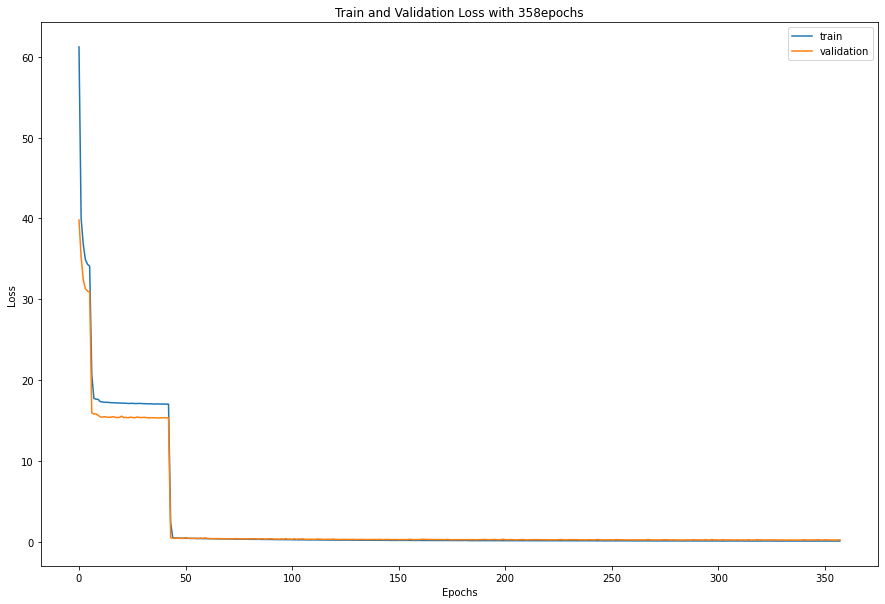

In [17]:
patience=25
# plotting training and validation history
plt.figure(figsize=(15,10))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [18]:
predict1=np.zeros((os)) #82
predict1=predictions[-3]
    
predict2=np.zeros((os))
predict2=predictions[-2]
    
predict3=np.zeros((os))
predict3=predictions[-1]

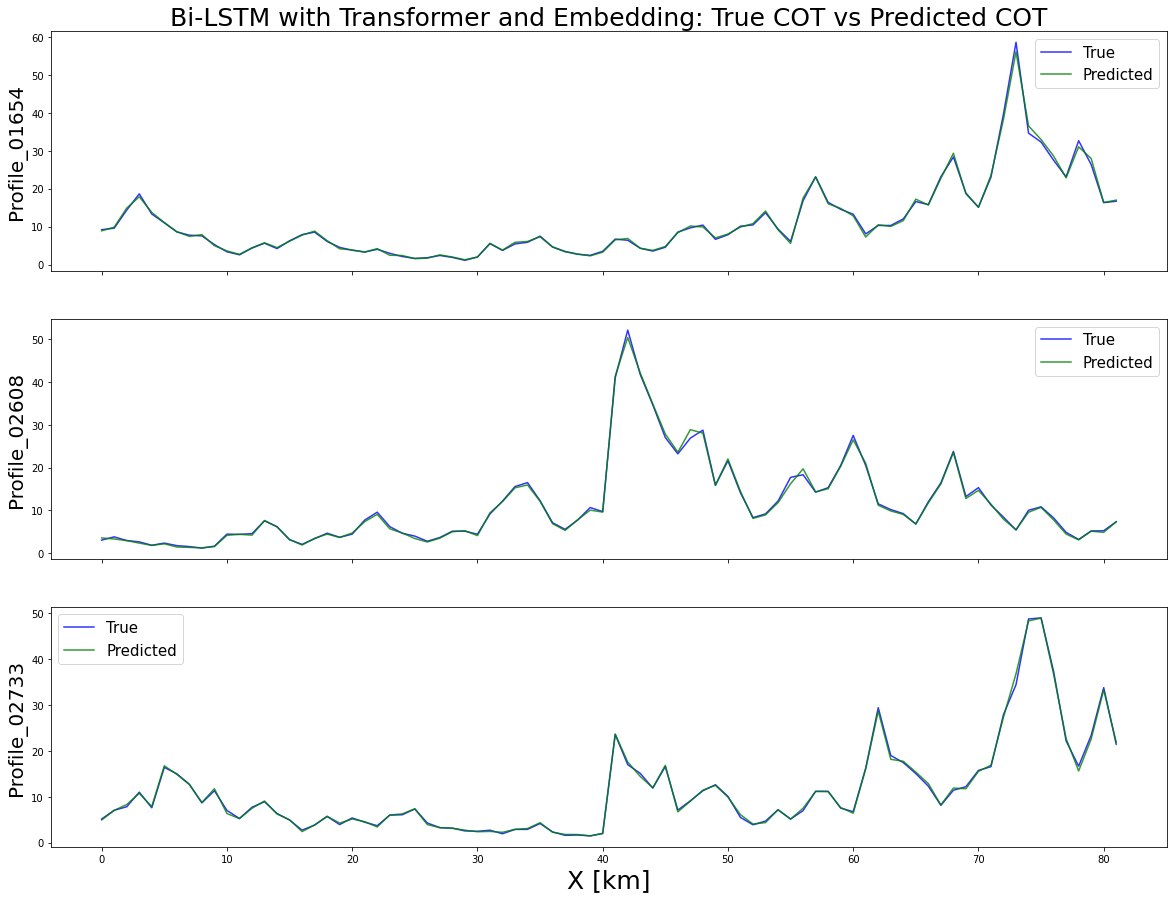

In [34]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM with transformer embedding"+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with Transformer and Embedding: True COT vs Predicted COT",fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.8,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.8,color="green") 
ax.legend(["True", "Predicted"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.8,color="blue")
ax.plot(range(82),predict2,alpha=0.8,color="green")
ax.legend(["True", "Predicted"],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.8,color="blue")
ax.plot(range(82),predict3,alpha=0.8,color="green")
ax.legend(["True", "Predicted"],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X [km]',fontsize=25)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [22]:
physics_retrieval1654=np.load('physics_retrieval1654.npy')
physics_retrieval2608=np.load('physics_retrieval2608.npy')
physics_retrieval2733=np.load('physics_retrieval2733.npy')


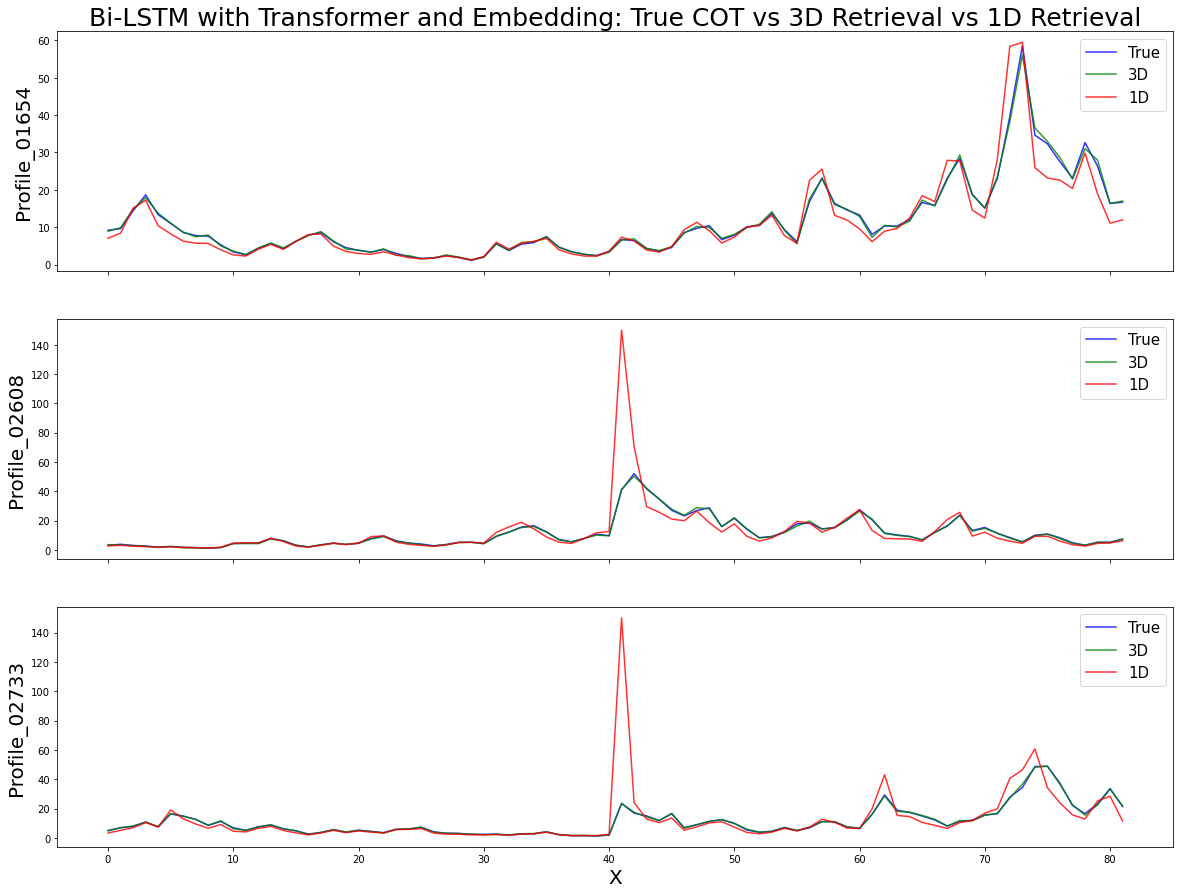

In [35]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/3_comparison_Bi-LSTM with transformer embedding SZA=60 VZA=0_500m"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with Transformer and Embedding: True COT vs 3D Retrieval vs 1D Retrieval",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.8,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.8,color="green")
ax.plot(range(82),physics_retrieval1654,alpha=0.8,color="red")

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20)

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2],alpha=0.8,color="blue")
ax.plot(range(82),predict2,alpha=0.8,color="green")
ax.plot(range(82),physics_retrieval2608,alpha=0.8,color="red")

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1],alpha=0.8,color="blue")
ax.plot(range(82),predict3,alpha=0.8,color="green")
ax.plot(range(82),physics_retrieval2733,alpha=0.8,color="red")

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X',fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [97]:

np.std([1.2912,1.2577,1.2629,1.2937,1.2571])

0.016416382061830777

# Plotting across predicted 82 COT values¶

In [75]:
std=[]
mean=[]

for k in range(os):#82
    tmp=[]
    for j in range(800): #test set
        tmp.append(np.abs(predictions[j][k]-test_label[j][k])) #absolute difference 
    std.append(np.std(tmp))
    mean.append(np.mean(tmp)) #### replace with RMSE 
    

std=np.array(std) #sd of the absolute difference of the 800 profiles at each cot values. 
mean=np.array(mean) #mean absolute difference between the predicted value and the orginal values of 800 profiles at each cot value
std1 = np.std(mean) #standard deviation of the mean absolute difference across the 82 cot values 

# plot std, std1
# histogram of mean and histogram of std


In [76]:
predictions.shape

(800, 82)

In [77]:
hist_m, bins_m = np.histogram(mean)
hist_s, bins_s = np.histogram(std)

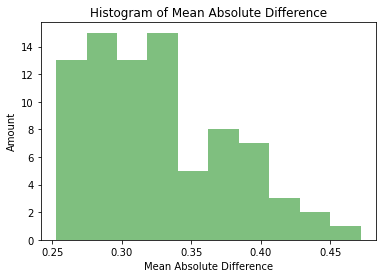

In [90]:
n, bins, patches = plt.hist(mean,bins=10,color='green',alpha=0.5)

plt.xlabel('Mean Absolute Difference')
plt.ylabel('Amount')

plt.title('Histogram of Mean Absolute Difference')

plt.show()

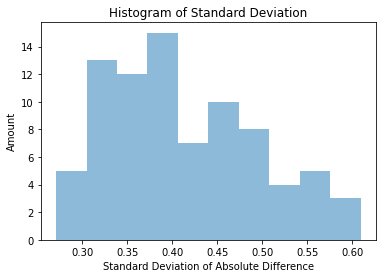

In [92]:
n, bins, patches = plt.hist(std,bins=10,histtype='bar',alpha=0.5)

plt.xlabel('Standard Deviation of Absolute Difference')
plt.ylabel('Amount')

plt.title('Histogram of Standard Deviation')

plt.show()

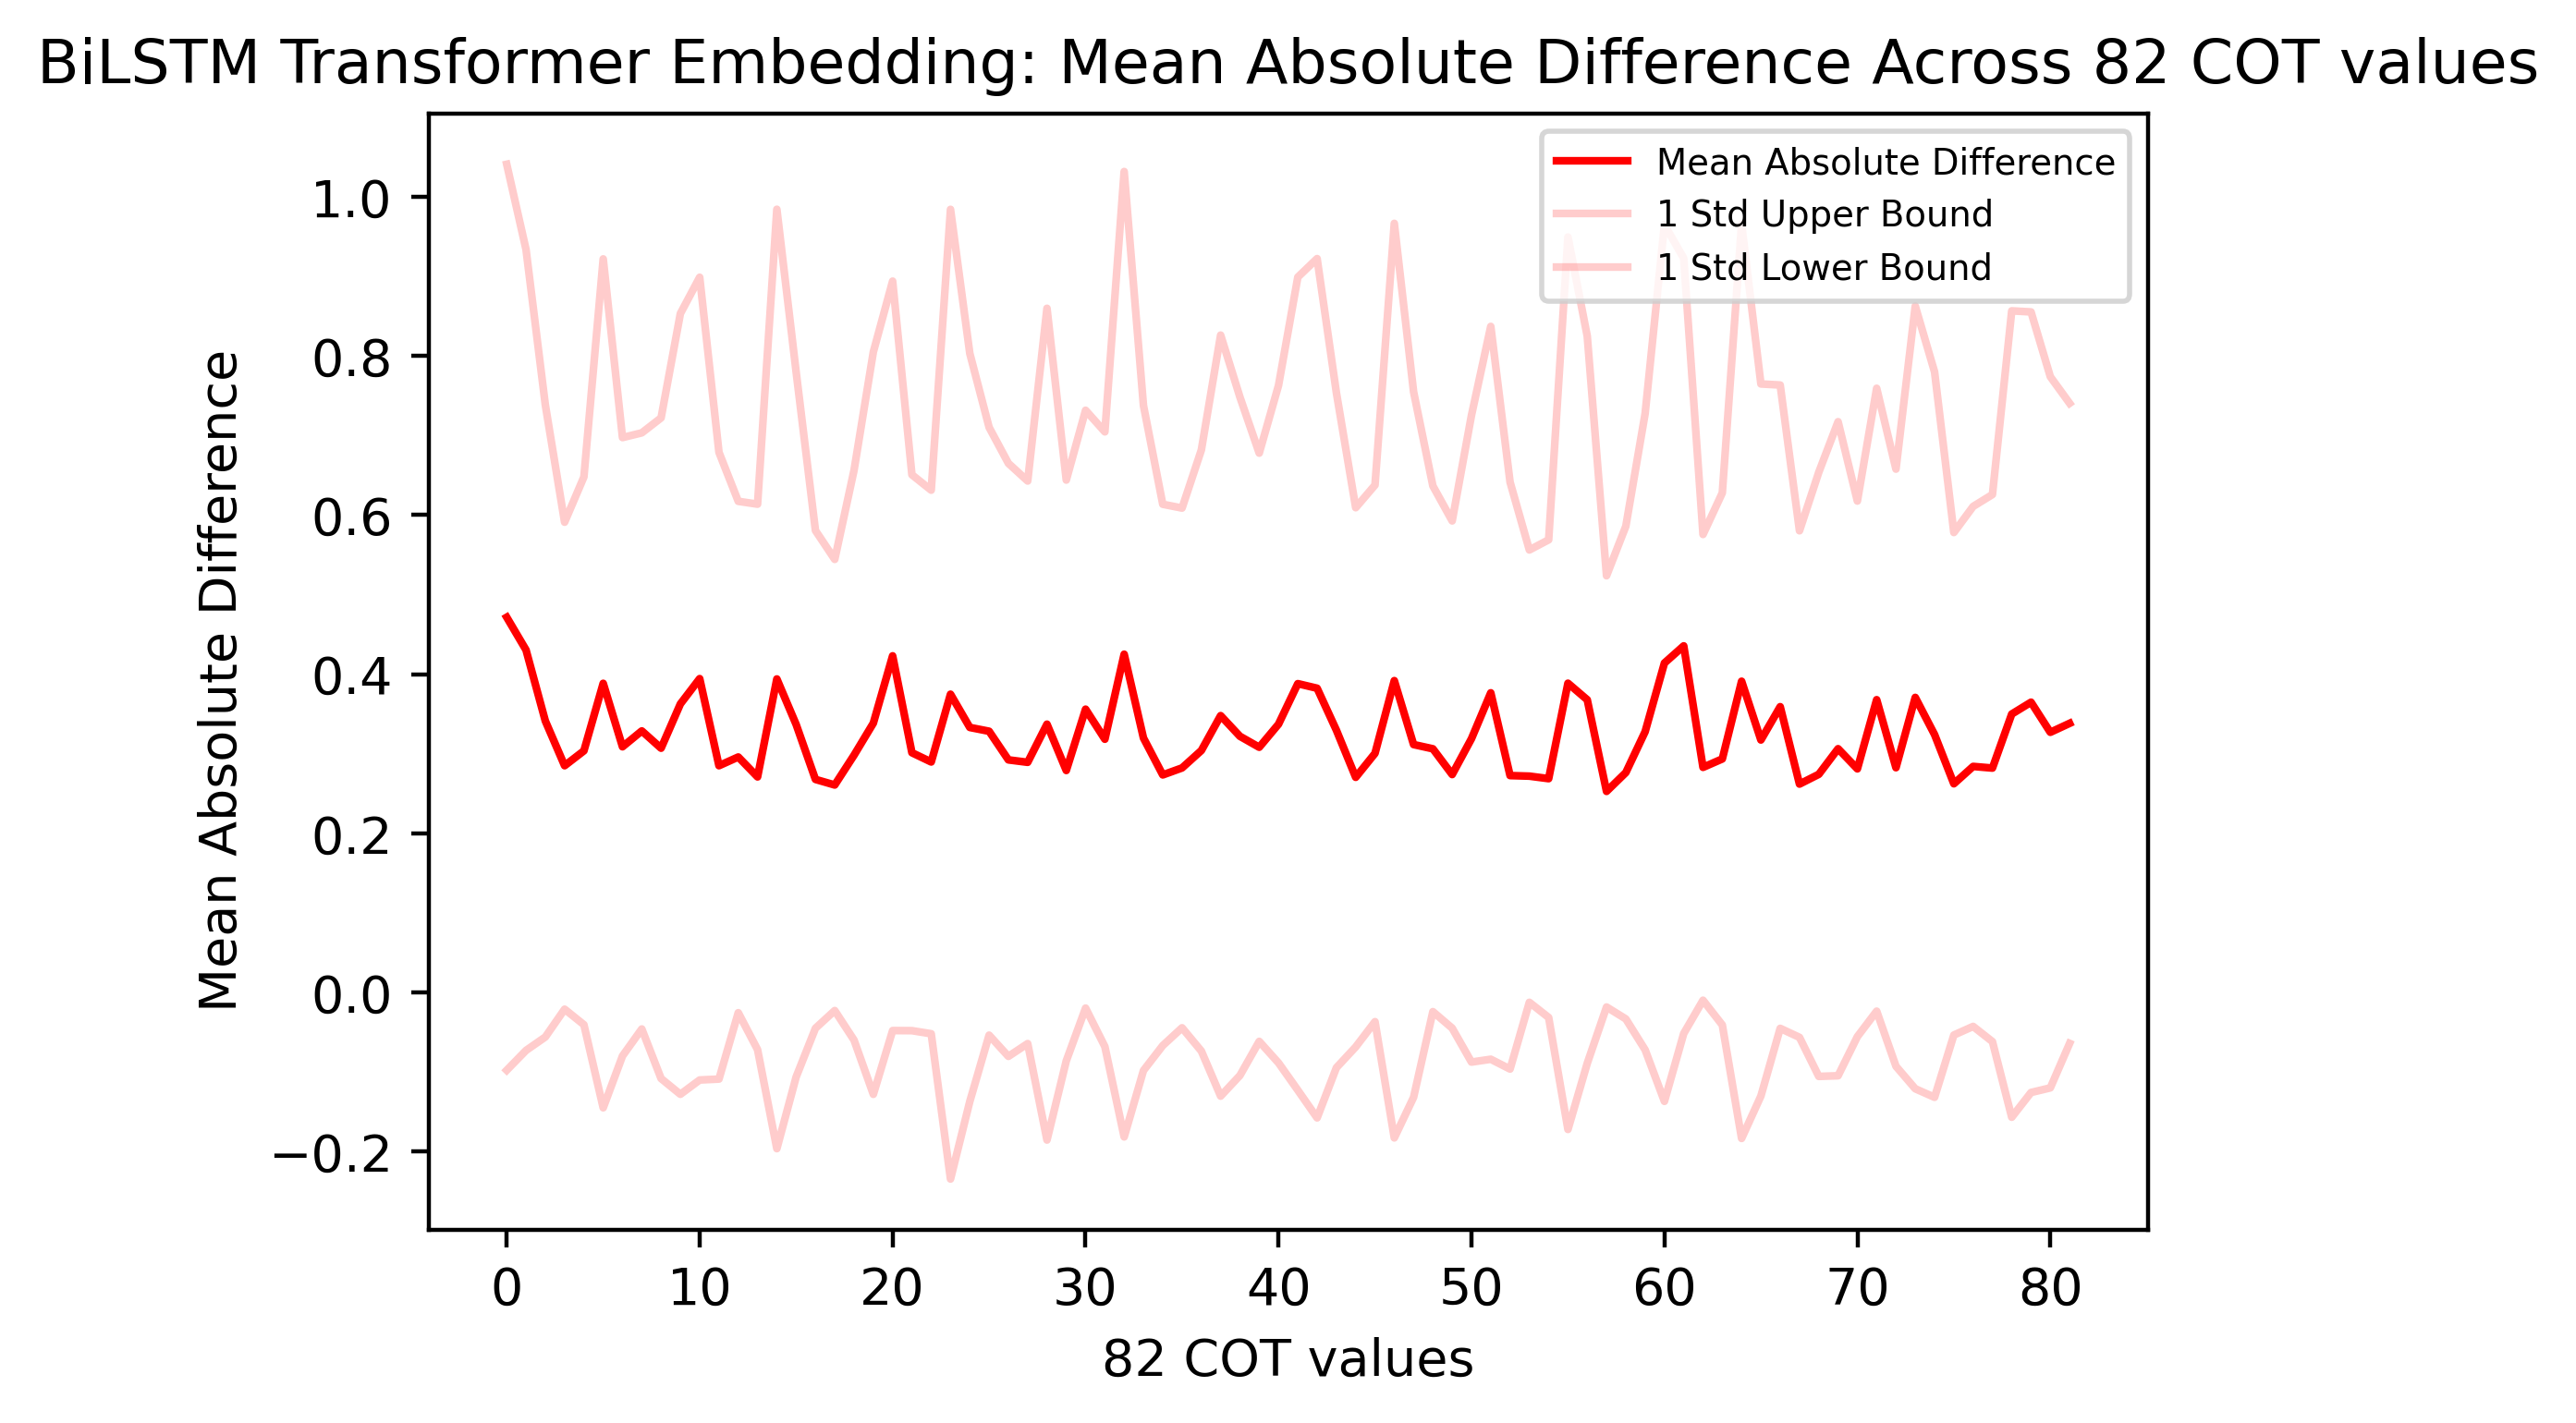

In [93]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
#ax.set_ylim((-0.5,1))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

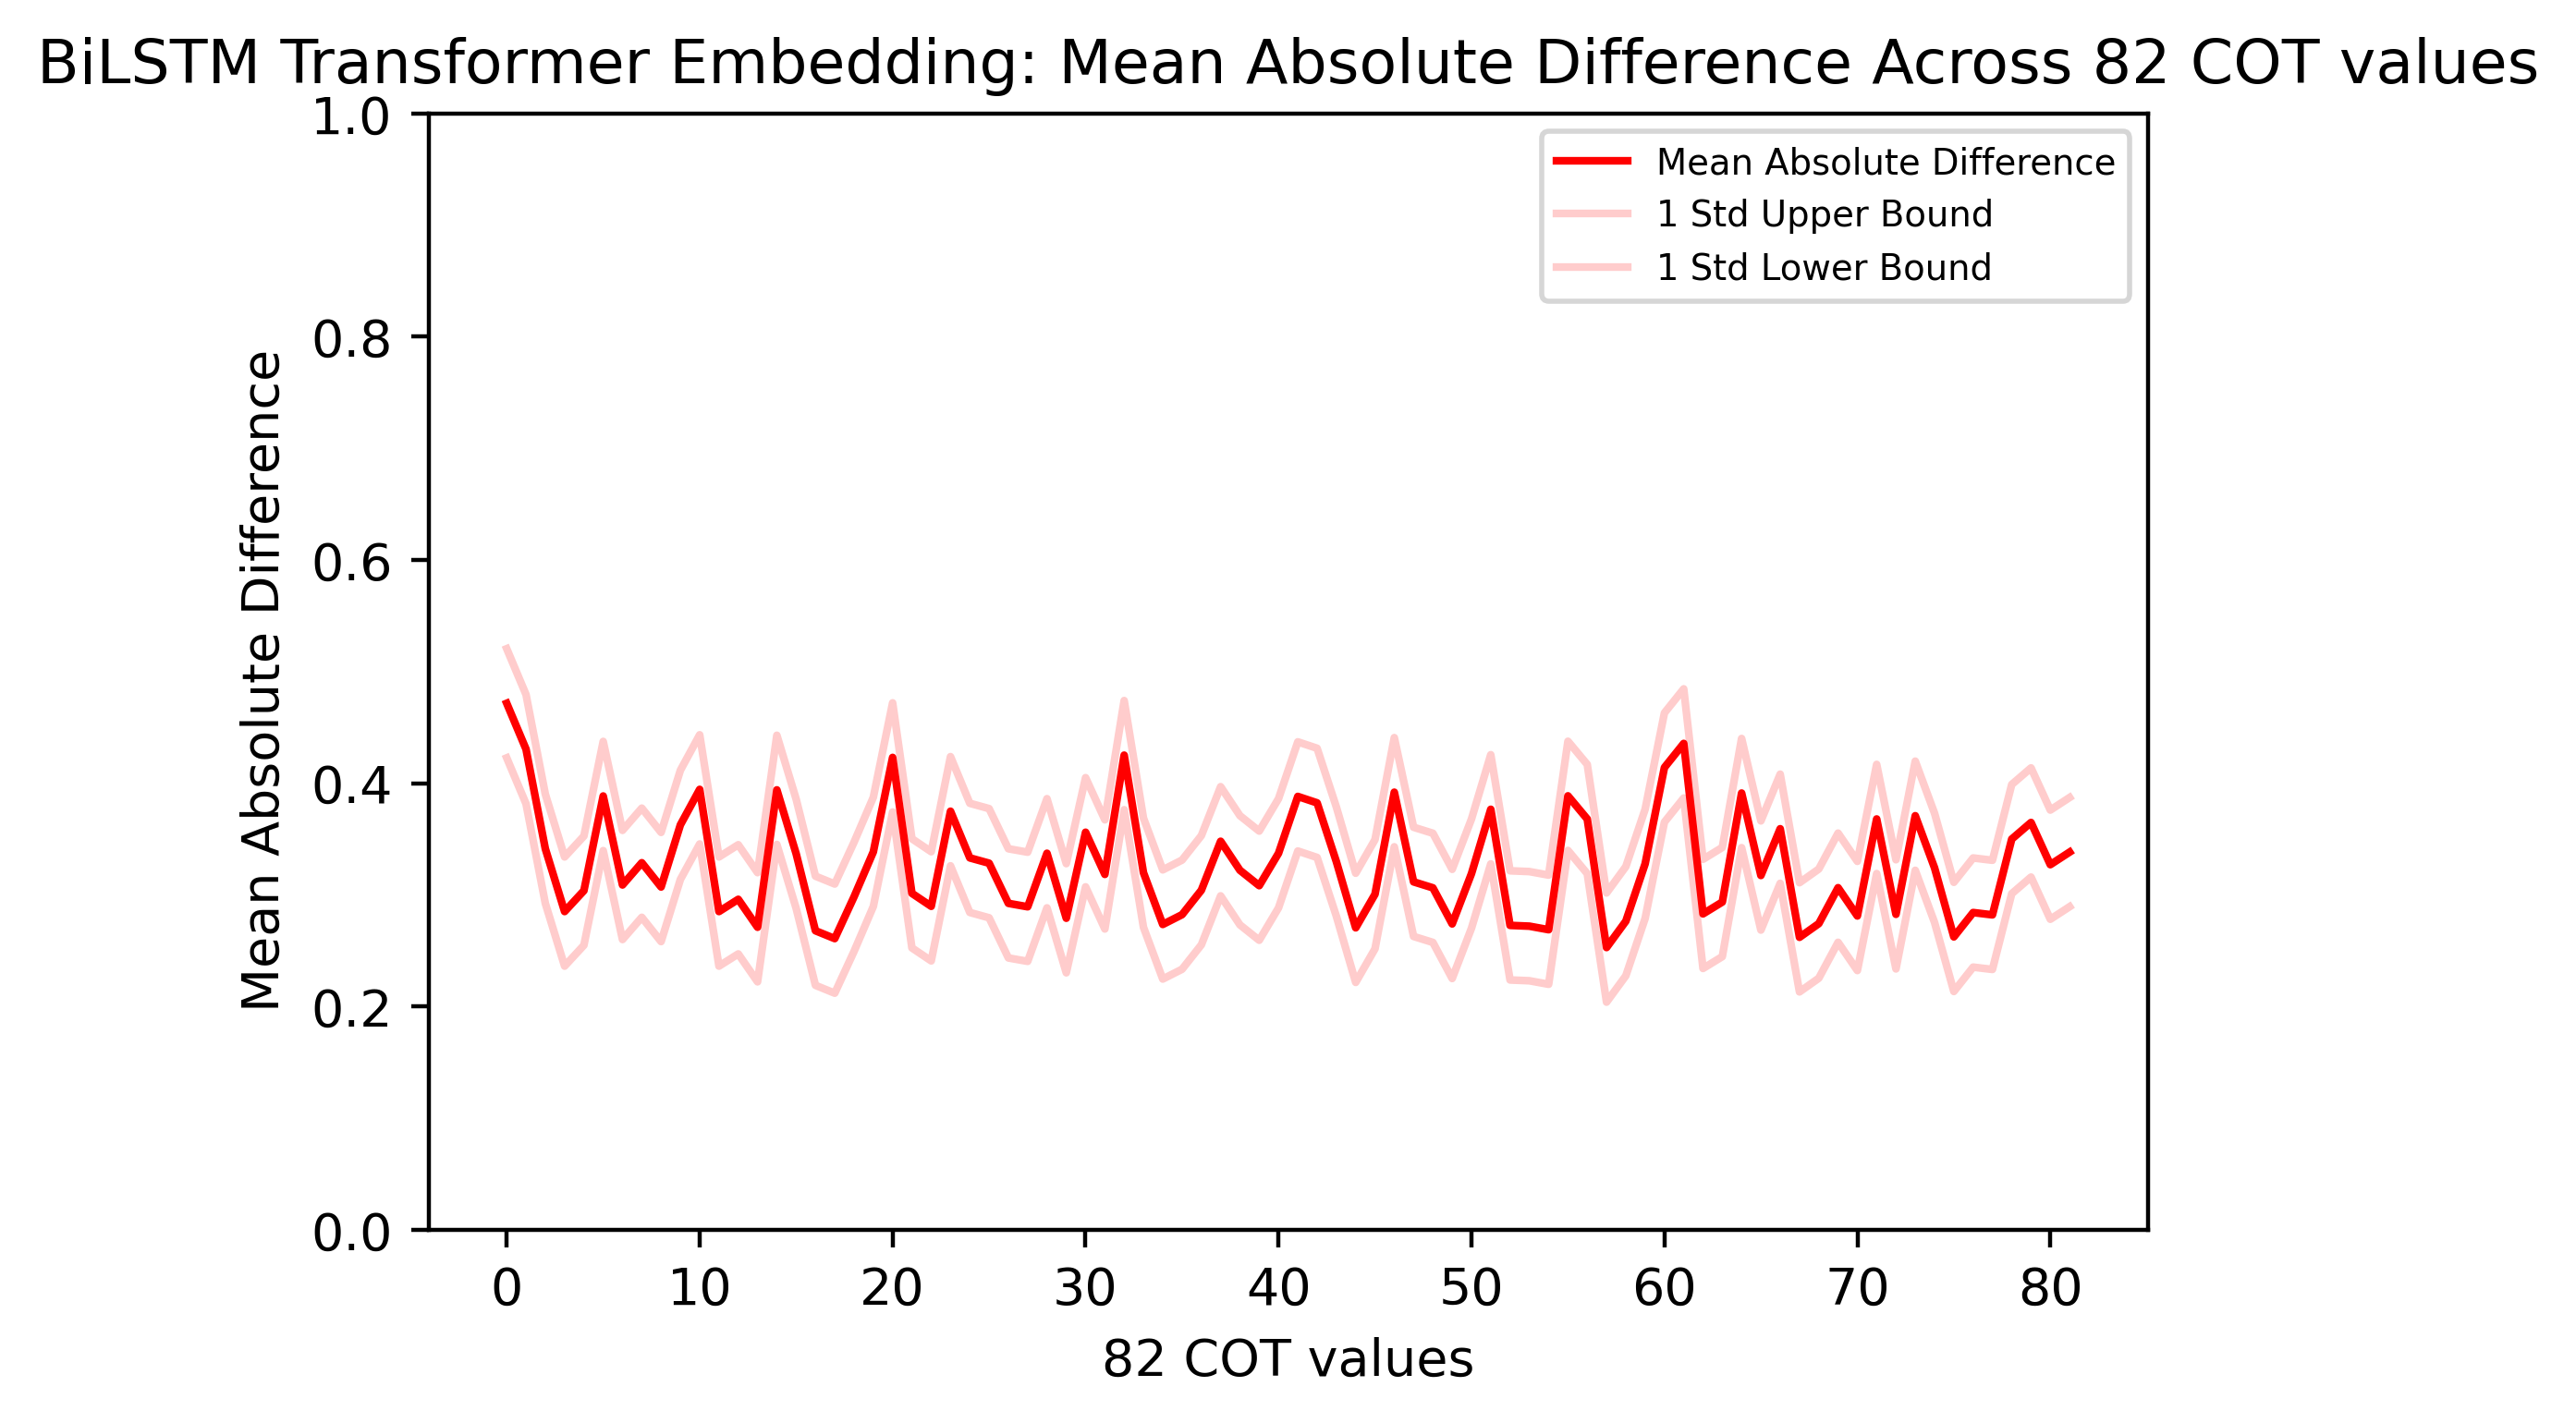

In [94]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((0,1))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)
